# Project Correction

## Set up

In [874]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [875]:
sns.set_theme()

In [876]:
# Load data
file_path = "masse-salariale-et-assiette-chomage-partiel-mensuelles-du-secteur-prive_modif.csv"
df = pd.read_csv(file_path, sep=';')

In [877]:
df.head(10)

,dernier_jour_du_mois,masse_salariale_brute,glissement_annuel_masse_salariale,assiette_chomage_partiel,part_assiette_chomage_partiel
0,2018-07-31,4.751144e+10,3.597676,0,0.095611
1,2018-12-31,4.600000e+00,3.319051,0,0.099413
2,2019-02-28,4.650688e+10,3.031088,0,0.127574
3,2019-12-31,4.600000e+00,1.949395,56070642,0.098110
4,2020-05-31,4.600000e+00,-18.501244,5026058436,11.315531
5,2020-06-30,4.811677e+10,-7.287336,2664957719,5.247868
6,2021-01-31,4.734466e+10,-2.672570,1397496188,2.867120
7,2021-08-31,4.883181e+10,6.042091,305335366,0.621394
8,2021-11-30,5.457379e+10,11.471635,0,0.445903
9,2021-12-31,4.600000e+00,8.992572,0,0.402537


In [878]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   dernier_jour_du_mois               50 non-null     object 
 1   masse_salariale_brute              49 non-null     float64
 2   glissement_annuel_masse_salariale  49 non-null     float64
 3   assiette_chomage_partiel           50 non-null     int64  
 4   part_assiette_chomage_partiel      50 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.1+ KB


In [879]:
# Cast date_col as datetime and sort
date_col = 'dernier_jour_du_mois'
df.index = pd.to_datetime(df[date_col])
df.drop(columns=date_col, inplace=True)
df.sort_index(inplace=True)
df.head()

,masse_salariale_brute,glissement_annuel_masse_salariale,assiette_chomage_partiel,part_assiette_chomage_partiel
dernier_jour_du_mois,,,,
2018-01-31,4.597808e+10,3.723658,65170920,0.141543
2018-02-28,4.513869e+10,3.382396,93043381,0.205704
2018-03-31,5.010227e+10,3.528660,77734990,0.154912
2018-04-30,4.759058e+10,4.056714,0,0.108859
2018-05-31,NaN,3.132336,49338347,0.105381


## Analysis

### Visualize time series

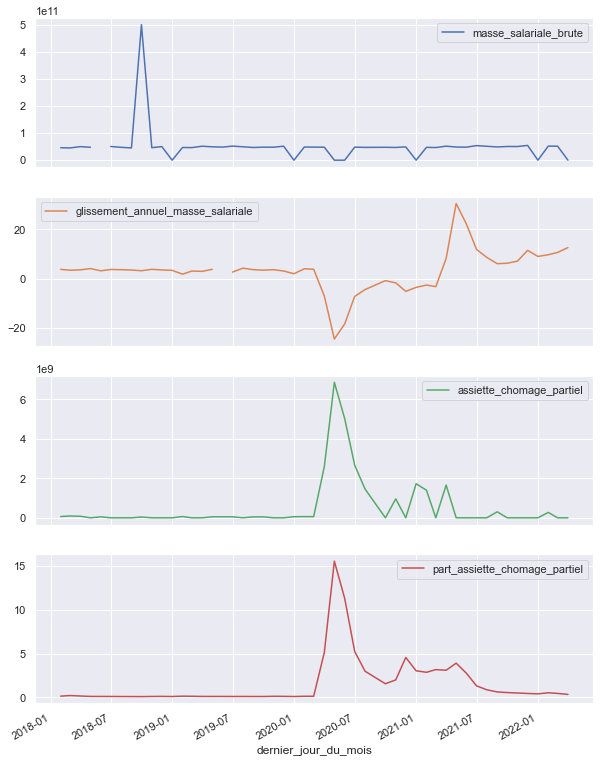

In [880]:
df.plot(subplots=True, figsize=(10, 14))
None

- We can see there is a sort of missing data somewhere, we'll handle that in a few moments

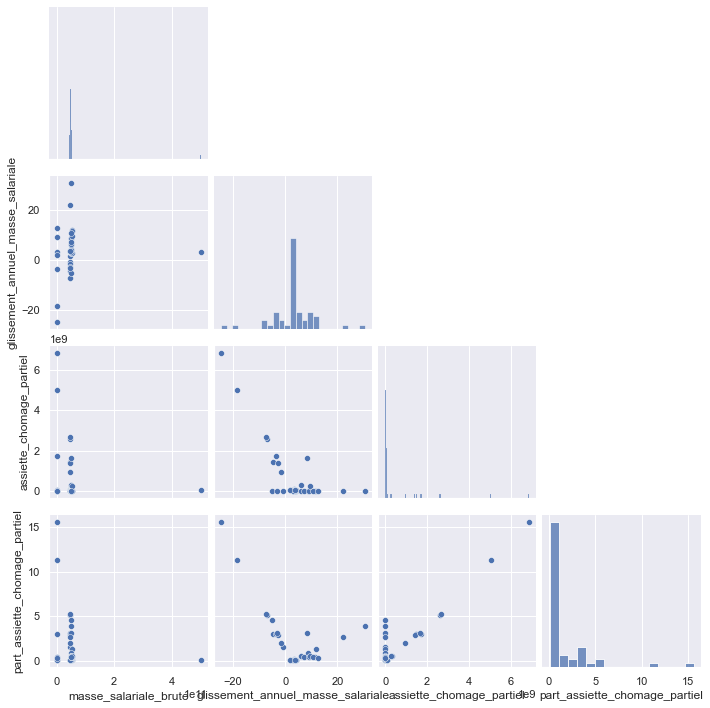

In [881]:
sns.pairplot(df, corner=True)

Analysis:
- Potential presence of outlier in *masse_salariale_brute*, since most of the points are crushed on the left side (one should be alone on the right)
- *glissement_annuel_masse_salariale* might be the variable closest to a normal law (but still far) - logical since the name suggests it has been computed as the evolution (often close to a normal law, see returns in finance, compared to their raw price)
- *part_assiette_chomage_partiel* and *assiette_chomage_partiel* show a positive linear relation (when one grows, the other grows too)

### Correlations
Pearson

<AxesSubplot:>

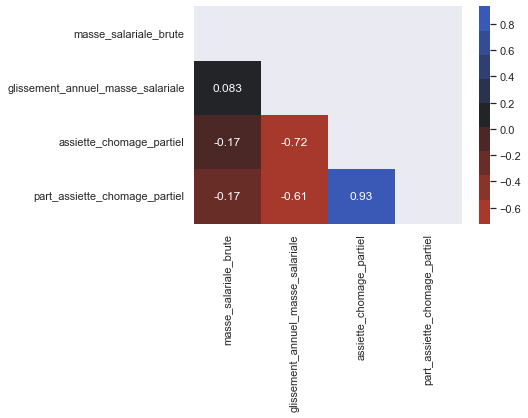

In [882]:
colormap = sns.diverging_palette(15, 260, s=75, l=40, n=9, center="dark")
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(), cmap=colormap, annot=True, mask=mask)

Analysis:
- All the features but *masses_salariale_brute* are highly correlated
- Thus, many information is redundant, only a single variable from those correlated above 50% should be kept
- Since *part_assiette_chomage_partiel* is the most correlated with *glissement_annuel_masse_salariale* and *assiette_chomage_partiel*, it is the variable that contains the most information. Hence will be kept while others will be deleted (in [Data Management](#data_management) section).

To go further:
- Use statistical tests to check the robustness of these results.
- They might otherwise be due to a sampling bias.

## Data Cleaning

### Check missing values

Find the missing date
- A row will be imputed (through linear interpolation)

In [883]:
# Check number of occurences for each year
df.index.year.value_counts()

2018    12
2019    12
2021    12
2020    11
2022     3
Name: dernier_jour_du_mois, dtype: int64

In [884]:
# Find the missing date in 2020
mask_2020 = df.index.year == 2020
[month for month in range(1, 13) if not month in df[mask_2020].index.month]

[8]

- The missing row is at 2020-08-31 (31 days in august)
- Will have to reconstruct using interpolation (mean between previous and next rows)

In [885]:
# Interpolate the missing row
interpolate_2020_08 = ((df.loc['2020-09-30'] + df.loc['2020-07-31']) / 2)
interpolate_2020_08 = pd.DataFrame(data=[interpolate_2020_08.values], columns=interpolate_2020_08.index, index=['2020-08-31'])
interpolate_2020_08.index = pd.to_datetime(interpolate_2020_08.index)
df = pd.concat([df, interpolate_2020_08])
df.sort_index(inplace=True)

In [886]:
# Check the right execution of intended imputation
df.loc[['2020-09-30', '2020-08-31', '2020-07-31']]

,masse_salariale_brute,glissement_annuel_masse_salariale,assiette_chomage_partiel,part_assiette_chomage_partiel
2020-09-30,4.761950e+10,-0.870150,0.000000e+00,1.557461
2020-08-31,4.744790e+10,-2.690735,7.286845e+08,2.273969
2020-07-31,4.727629e+10,-4.511321,1.457369e+09,2.990477


### Check for NAs

In [887]:
df.isna().sum()

masse_salariale_brute                1
glissement_annuel_masse_salariale    1
assiette_chomage_partiel             0
part_assiette_chomage_partiel        0
dtype: int64

In [888]:
# Easy imputation of NaN:
# - coherent since there is a single NaN in the two columns
# - coherent since the values seem to have a linear relation
# - Use bfill as it prevents the risk of data leakage (using future values for imputation of past values)
df.fillna(method='bfill', inplace=True)

To go further:
- Variables can be used to impute the missing value in *masse_salariale_brute*, with a linear or non-linear imputer

### Detect outliers

In [903]:
bound_max = df.mean() + df.std() * 2
bound_min = df.mean() - df.std() * 2
mask_outliers_array = (df > bound_max) | (df < bound_min)
df[mask_outliers_array['masse_salariale_brute']]

,masse_salariale_brute,glissement_annuel_masse_salariale,assiette_chomage_partiel,part_assiette_chomage_partiel
2018-09-30,5.000000e+11,3.164464,39769110.0,0.085523


In [905]:
df[mask_outliers_array['glissement_annuel_masse_salariale']]

,masse_salariale_brute,glissement_annuel_masse_salariale,assiette_chomage_partiel,part_assiette_chomage_partiel
2020-04-30,4.600000e+00,-24.649473,6.864317e+09,15.576859
2020-05-31,4.600000e+00,-18.501244,5.026058e+09,11.315531
2021-04-30,4.856824e+10,30.548969,0.000000e+00,3.912326
2021-05-31,4.809593e+10,22.097902,0.000000e+00,2.743861


In [906]:
df[mask_outliers_array['assiette_chomage_partiel']]

,masse_salariale_brute,glissement_annuel_masse_salariale,assiette_chomage_partiel,part_assiette_chomage_partiel
2020-04-30,4.6,-24.649473,6.864317e+09,15.576859
2020-05-31,4.6,-18.501244,5.026058e+09,11.315531


In [907]:
df[mask_outliers_array['part_assiette_chomage_partiel']]

,masse_salariale_brute,glissement_annuel_masse_salariale,assiette_chomage_partiel,part_assiette_chomage_partiel
2020-04-30,4.6,-24.649473,6.864317e+09,15.576859
2020-05-31,4.6,-18.501244,5.026058e+09,11.315531


## Data Management
<a id='data_management'></a>

### Drop features

In [864]:
# Delete useless redundant information
df.drop(columns='part_assiette_chomage_partiel', inplace=True)

In [865]:
# Delete features with excessive correlation ±60% (multi-colinearity)
# As the name suggests "glissement_annuel_masse_salariale",
# the variable might be derived directly from "masse_salariale_brute"
df.drop(columns='glissement_annuel_masse_salariale', inplace=True)

In [866]:
df.head()

,masse_salariale_brute,assiette_chomage_partiel
2018-01-31,4.597808e+10,65170920.0
2018-02-28,4.513869e+10,93043381.0
2018-03-31,5.010227e+10,77734990.0
2018-04-30,4.759058e+10,0.0
2018-05-31,5.057610e+10,49338347.0


We are left with 2 time series

## Feature Engineering

## Prediction
- Regression
- Time Series
- Predict the future

### Prepare data for time series prediction
- split train and test (70% train, 30% test)
- extract features (X) and target (y)
- shift features (this enables to find the link between old features values and current target values)

In [867]:
# Train / Test Split
PCT_TRAIN = .70

last_train = int(df.shape[0] * PCT_TRAIN)
train = df.iloc[:last_train]
test = df.iloc[last_train:]

# For the plot only
train_index = df.index[:last_train]
test_index = df.index[last_train:]

In [868]:
# Features vs Target (and shift)
TARGET = 'masse_salariale_brute'
N_DELAY = 4  # months to predict ahead

X_train = train.shift(N_DELAY)  # use data n months before to predict today
X_train = X_train.iloc[N_DELAY:]
y_train = train[TARGET].iloc[N_DELAY:]
train_index = train_index[N_DELAY:]  # For the plot only

X_test = test.shift(N_DELAY)
X_test = X_test.iloc[N_DELAY:]
y_test = test[TARGET].iloc[N_DELAY:]
test_index = test_index[N_DELAY:]  # For the plot only

### Model
- Train
- Evaluate (test)
- Predict

In [869]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [870]:
# Make a pipeline to automate transformation of the input
# On both train and test sets
DEGREE = 2
poly = PolynomialFeatures(DEGREE, include_bias=False)
model = LinearRegression()
pipeline = Pipeline(steps=[('t', poly), ('m', model)])

In [871]:
# Train model
poly_reg_model = pipeline.fit(X_train, y_train)

# Evaluate model on train (predict on the train set)
y_train_pred = poly_reg_model.predict(X_train)
print(f'Train R^2: {poly_reg_model.score(X_train, y_train):.2f}')

# Evaluate model on test (predict on the test set)
y_test_pred = poly_reg_model.predict(X_test)
print(f'Test R^2: {poly_reg_model.score(X_test, y_test):.2f}')

Train R^2: 0.02
Test R^2: -1.28


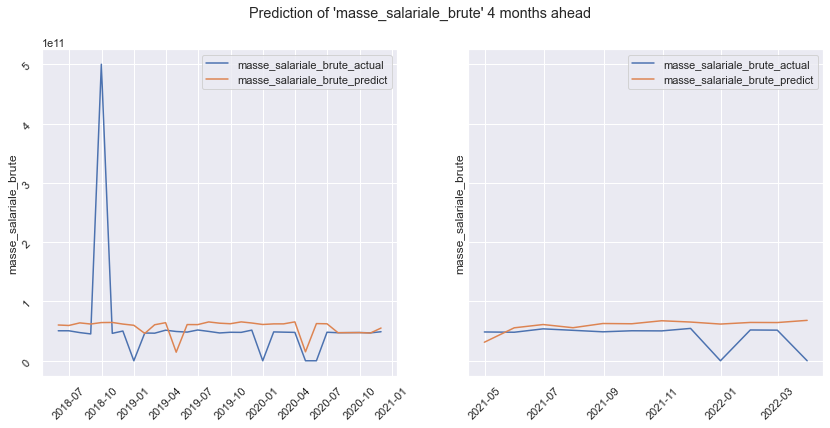

In [872]:
# Define figure (whole white frame and space for each plot)
fig, ax = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# Left plot (train)
ax[0].plot(train_index, y_train)
ax[0].plot(train_index, y_train_pred)
ax[0].tick_params(labelrotation=45)
ax[0].legend([f'{TARGET}_actual', f'{TARGET}_predict'])
ax[0].set_ylabel(TARGET)

# Right plot (train)
ax[1].plot(test_index, y_test)
ax[1].plot(test_index, y_test_pred)
ax[1].tick_params(labelrotation=45)
ax[1].legend([f'{TARGET}_actual', f'{TARGET}_predict'])
ax[1].set_ylabel(TARGET)

fig.suptitle(f"Prediction of 'masse_salariale_brute' {N_DELAY} months ahead")
plt.show()

The performance is very poor using this model on these data.

Going further:
- try the model SARIMAX
- try the model XGBOOST
- Look for complementary data (very often this is more powerful than playing with models)